In [3]:
#reference:
#https://github.com/atulkum/sequence_prediction/blob/master/neural_ner/process_training.py
#https://www.cse.chalmers.se/~richajo/nlp2019/l6/Sequence%20tagging%20example.html
#https://stackoverflow.com/questions/66516388/attributeerror-module-torchtext-data-has-no-attribute-field

In [4]:
!pip install torch

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [5]:
!pip install pytorch-crf

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [6]:
!pip install torchtext==0.10.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [7]:
import sys
sys.path.append("/Users/lsc/opt/anaconda3/envs/deep/lib/python2.7/site-packages")

**Sequence tagging example**




In this example, we implement a named entity tagger using two different approaches: a simple approach where a linear output unit is put on top of an RNN, and a slightly more complex approach where we use a conditional random field to predict the output. This example uses training and validation data from the [CoNLL-2003 Shared Task](https://www.cse.chalmers.se/~richajo/nlp2019/l6/Sequence%20tagging%20example.html#:~:text=CoNLL-2003%20Shared%20Task.).

In [8]:
import torch
from torch import nn
import time
import torchtext
import numpy as np

import random

from collections import defaultdict, Counter

import matplotlib.pyplot as plt

%config InlineBackend.figure_format = 'retina' 
plt.style.use('seaborn')

# Reading the data in the CoNLL-2003 format

Reading the data in the CoNLL-2003 format.

The CoNLL-2003 shared task data files contain four columns separated by a single space. Each word has been put on a separate line and there is an empty line after each sentence. The first item on each line is a word, the second a part-of-speech (POS) tag, the third a syntactic chunk tag and the fourth the named entity tag. The chunk tags and the named entity tags have the format I-TYPE which means that the word is inside a phrase of type TYPE. Only if two phrases of the same type immediately follow each other, the first word of the second phrase will have tag B-TYPE to show that it starts a new phrase. A word with tag O is not part of a phrase. 
Here is an example:

EU NNP I-NP I-ORG
rejects VBZ I-VP O
German JJ I-NP I-MISC
call NN I-NP O
to TO I-VP O
boycott VB I-VP O
British JJ I-NP I-MISC
lamb NN I-NP O
. . O O

In [9]:
def read_data(corpus_file, datafields):
    with open(corpus_file, encoding='utf-8') as f:
        examples = []
        words = []
        labels = []
        for line in f:
            line = line.strip()
            if not line:
                #examples.append(torchtext.data.Example.fromlist([words, labels], datafields))
                examples.append(torchtext.legacy.data.Example.fromlist([words, labels], datafields))
              
                words = []
                labels = []
            else:
                columns = line.split()
                words.append(columns[0])
                labels.append(columns[-1])
        #return torchtext.data.Dataset(examples, datafields)
        return torchtext.legacy.data.Dataset(examples, datafields)

# Implementing a tagger based on RNNs and a linear output unit

Our first implementation will be fairly straightforward. We apply an RNN and then a linear output unit to predict the outputs.

High-quality systems that for tasks such as named entity recognition and part-of-speech tagging typically use smarter word representations, for instance by taking the characters into account more carefully. We just use word embeddings.

A small issue to note here is that we don't want the system to spend effort learning to tag the padding tokens. To make the system ignore the padding, we add a large number to the output corresponding to the dummy padding tag. This means that the loss values for these positions will be negligible.

In [10]:
class RNNTagger(nn.Module):
    
    def __init__(self, text_field, label_field, emb_dim, rnn_size, update_pretrained=False):
        super().__init__()
        
        voc_size = len(text_field.vocab)
        self.n_labels = len(label_field.vocab)       
        
        # Embedding layer. If we're using pre-trained embeddings, copy them
        # into our embedding module.
        self.embedding = nn.Embedding(voc_size, emb_dim)
        if text_field.vocab.vectors is not None:
            self.embedding.weight = torch.nn.Parameter(text_field.vocab.vectors, 
                                                       requires_grad=update_pretrained)

        # RNN layer. We're using a bidirectional GRU with one layer.
        self.rnn = nn.GRU(input_size=emb_dim, hidden_size=rnn_size, 
                          bidirectional=True, num_layers=1)

        # Output layer. As in the example last week, the input will be two times
        # the RNN size since we are using a bidirectional RNN.
        self.top_layer = nn.Linear(2*rnn_size, self.n_labels)
 
        # To deal with the padding positions later, we need to know the
        # encoding of the padding dummy word and the corresponding dummy output tag.
        self.pad_word_id = text_field.vocab.stoi[text_field.pad_token]
        self.pad_label_id = label_field.vocab.stoi[label_field.pad_token]
    
        # Loss function that we will use during training.
        self.loss = torch.nn.CrossEntropyLoss(reduction='sum')
        
    def compute_outputs(self, sentences):
        # The words in the documents are encoded as integers. The shape of the documents
        # tensor is (max_len, n_docs), where n_docs is the number of documents in this batch,
        # and max_len is the maximal length of a document in the batch.

        # First look up the embeddings for all the words in the documents.
        # The shape is now (max_len, n_sentences, emb_dim).        
        embedded = self.embedding(sentences)

        # Apply the RNN.
        # The shape of the RNN output tensor is (max_len, n_sentences, 2*rnn_size).
        rnn_out, _ = self.rnn(embedded)
        
        # Apply the linear output layer.
        # The shape of the output tensor is (max_len, n_sentences, n_labels).
        out = self.top_layer(rnn_out)
        
        # Find the positions where the token is a dummy padding token.
        pad_mask = (sentences == self.pad_word_id).float()

        # For these positions, we add some large number in the column corresponding
        # to the dummy padding label.
        out[:, :, self.pad_label_id] += pad_mask*10000

        return out
                
    def forward(self, sentences, labels):
        # As discussed above, this method first computes the predictions, and then
        # the loss function.
        
        # Compute the outputs. The shape is (max_len, n_sentences, n_labels).
        scores = self.compute_outputs(sentences)
        
        # Flatten the outputs and the gold-standard labels, to compute the loss.
        # The input to this loss needs to be one 2-dimensional and one 1-dimensional tensor.
        scores = scores.view(-1, self.n_labels)
        labels = labels.view(-1)
        return self.loss(scores, labels)

    def predict(self, sentences):
        # Compute the outputs from the linear units.
        scores = self.compute_outputs(sentences)

        # Select the top-scoring labels. The shape is now (max_len, n_sentences).
        predicted = scores.argmax(dim=2)

        # We transpose the prediction to (n_sentences, max_len), and convert it
        # to a NumPy matrix.
        return predicted.t().cpu().numpy()

# Implementing a conditional random field tagger

We will now add a CRF layer on top of the linear output units. The CRF will help the model handle the interactions between output tags more consistently, e.g. not mixing up B and I tags of different types. 

The two important methods in [the CRF module](https://pytorch-crf.readthedocs.io/en/stable/) correspond to the two main algorithm that a CRF needs to implement:

**Decode** applies the Viterbi algorithm to compute the highest-scoring sequences.

**Forward** applies the forward algorithm to compute the log likelihood of the training set.
Most of the code is identical to the implementation above. The differences are in the forward and predict methods.

In [11]:
from torchcrf import CRF

class RNNCRFTagger(nn.Module):
    
    def __init__(self, text_field, label_field, emb_dim, rnn_size, update_pretrained=False):
        super().__init__()
        
        voc_size = len(text_field.vocab)
        self.n_labels = len(label_field.vocab)       
        
        self.embedding = nn.Embedding(voc_size, emb_dim)
        if text_field.vocab.vectors is not None:
            self.embedding.weight = torch.nn.Parameter(text_field.vocab.vectors, 
                                                       requires_grad=update_pretrained)

        self.rnn = nn.GRU(input_size=emb_dim, hidden_size=rnn_size, 
                          bidirectional=True, num_layers=1)

        self.top_layer = nn.Linear(2*rnn_size, self.n_labels)
 
        self.pad_word_id = text_field.vocab.stoi[text_field.pad_token]
        self.pad_label_id = label_field.vocab.stoi[label_field.pad_token]
    
        self.crf = CRF(self.n_labels)
        
    def compute_outputs(self, sentences):
        embedded = self.embedding(sentences)
        rnn_out, _ = self.rnn(embedded)
        out = self.top_layer(rnn_out)
        
        pad_mask = (sentences == self.pad_word_id).float()
        out[:, :, self.pad_label_id] += pad_mask*10000
        
        return out
                
    def forward(self, sentences, labels):
        # Compute the outputs of the lower layers, which will be used as emission
        # scores for the CRF.
        scores = self.compute_outputs(sentences)

        # We return the loss value. The CRF returns the log likelihood, but we return 
        # the *negative* log likelihood as the loss value.            
        # PyTorch's optimizers *minimize* the loss, while we want to *maximize* the
        # log likelihood.
        return -self.crf(scores, labels)
            
    def predict(self, sentences):
        # Compute the emission scores, as above.
        scores = self.compute_outputs(sentences)

        # Apply the Viterbi algorithm to get the predictions. This implementation returns
        # the result as a list of lists (not a tensor), corresponding to a matrix
        # of shape (n_sentences, max_len).
        return self.crf.decode(scores)

# Evaluating the predicted named entities

To evaluate our named entity recognizers, we compare the named entities predicted by the system to the entities in the gold standard. We follow standard practice and compute precision and recall scores, as well as the harmonic mean of the precision and recall, known as the F-score.

Please note that the precision and recall scores are computed with respect to the full named entity spans and labels. To be counted as a correct prediction, the system needs to predict all words in the named entity correctly, and assign the right type of entity label. We don't give any credits to partially correct predictions.

**Note:**Two packages of training and validation data sets are given. You can use any package.

**eng.train&eng.test**(original Conll03 corpus)
**eng.train.openNLP&eng.test.openNL**P(retagging of Conll03 with openNLP,there are many tags that differ from the original Conll03 corpus: estimation at 12% of different tags)


In [12]:
# Convert a list of BIO labels, coded as integers, into spans identified by a beginning, an end, and a label.
# To allow easy comparison later, we store them in a dictionary indexed by the start position.
def to_spans(l_ids, voc):
    spans = {}
    current_lbl = None
    current_start = None
    for i, l_id in enumerate(l_ids):
        l = voc[l_id]

        if l[0] == 'B': 
            # Beginning of a named entity: B-something.
            if current_lbl:
                # If we're working on an entity, close it.
                spans[current_start] = (current_lbl, i)
            # Create a new entity that starts here.
            current_lbl = l[2:]
            current_start = i
        elif l[0] == 'I':
            # Continuation of an entity: I-something.
            if current_lbl:
                # If we have an open entity, but its label does not
                # correspond to the predicted I-tag, then we close
                # the open entity and create a new one.
                if current_lbl != l[2:]:
                    spans[current_start] = (current_lbl, i)
                    current_lbl = l[2:]
                    current_start = i
            else:
                # If we don't have an open entity but predict an I tag,
                # we create a new entity starting here even though we're
                # not following the format strictly.
                current_lbl = l[2:]
                current_start = i
        else:
            # Outside: O.
            if current_lbl:
                # If we have an open entity, we close it.
                spans[current_start] = (current_lbl, i)
                current_lbl = None
                current_start = None
    return spans

# Compares two sets of spans and records the results for future aggregation.
def compare(gold, pred, stats):
    for start, (lbl, end) in gold.items():
        stats['total']['gold'] += 1
        stats[lbl]['gold'] += 1
    for start, (lbl, end) in pred.items():
        stats['total']['pred'] += 1
        stats[lbl]['pred'] += 1
    for start, (glbl, gend) in gold.items():
        if start in pred:
            plbl, pend = pred[start]
            if glbl == plbl and gend == pend:
                stats['total']['corr'] += 1
                stats[glbl]['corr'] += 1

# This function combines the auxiliary functions we defined above.
def evaluate_iob(predicted, gold, label_field, stats):
    # The gold-standard labels are assumed to be an integer tensor of shape
    # (max_len, n_sentences), as returned by torchtext.
    gold_cpu = gold.t().cpu().numpy()
    gold_cpu = list(gold_cpu.reshape(-1))

    # The predicted labels assume the format produced by pytorch-crf, so we
    # assume that they have been converted into a list already.
    # We just flatten the list.
    pred_cpu = [l for sen in predicted for l in sen]
    
    # Compute spans for the gold standard and prediction.
    gold_spans = to_spans(gold_cpu, label_field.vocab.itos)
    pred_spans = to_spans(pred_cpu, label_field.vocab.itos)

    # Finally, update the counts for correct, predicted and gold-standard spans.
    compare(gold_spans, pred_spans, stats)

# Computes precision, recall and F-score, given a dictionary that contains
# the counts of correct, predicted and gold-standard items.
def prf(stats):
    if stats['pred'] == 0:
        return 0, 0, 0
    p = stats['corr']/stats['pred']
    r = stats['corr']/stats['gold']
    if p > 0 and r > 0:
        f = 2*p*r/(p+r)
    else:
        f = 0
    return p, r, f

# Training the full system
The training procedure will create a model, train it for some epochs, and evaluate on the validation set periodically. In most cases, the CRF-based system gives slightly higher evaluation scores than the simple system.

We are training word embeddings from scratch.
built vocab from training examples.
training beginning.


/usr/local/lib/python3.7/dist-packages/torchcrf/__init__.py:249: UserWarning: where received a uint8 condition tensor. This behavior is deprecated and will be removed in a future version of PyTorch. Use a boolean condition instead. (Triggered internally at  /pytorch/aten/src/ATen/native/TensorCompare.cpp:255.)
  score = torch.where(mask[i].unsqueeze(1), next_score, score)


Epoch 1: train loss = 0.5472, val f1: 0.2610, time = 1.8786
Epoch 2: train loss = 0.3013, val f1: 0.5279, time = 1.7294
Epoch 3: train loss = 0.1800, val f1: 0.6406, time = 1.7379
Epoch 4: train loss = 0.1329, val f1: 0.6634, time = 1.7383
Epoch 5: train loss = 0.1160, val f1: 0.7001, time = 1.7279
Epoch 6: train loss = 0.1004, val f1: 0.6748, time = 1.7255
Epoch 7: train loss = 0.0921, val f1: 0.7439, time = 1.7491
Epoch 8: train loss = 0.0824, val f1: 0.7728, time = 1.7399
Epoch 9: train loss = 0.0834, val f1: 0.7185, time = 1.7432
Epoch 10: train loss = 0.0865, val f1: 0.7289, time = 1.7280
Epoch 11: train loss = 0.0790, val f1: 0.7479, time = 1.7417
Epoch 12: train loss = 0.0809, val f1: 0.7710, time = 1.7459
Epoch 13: train loss = 0.0719, val f1: 0.7173, time = 1.7580
Epoch 14: train loss = 0.0666, val f1: 0.7314, time = 1.7424
Epoch 15: train loss = 0.0562, val f1: 0.7803, time = 1.7515
Epoch 16: train loss = 0.0642, val f1: 0.7713, time = 1.7579
Epoch 17: train loss = 0.0734, va

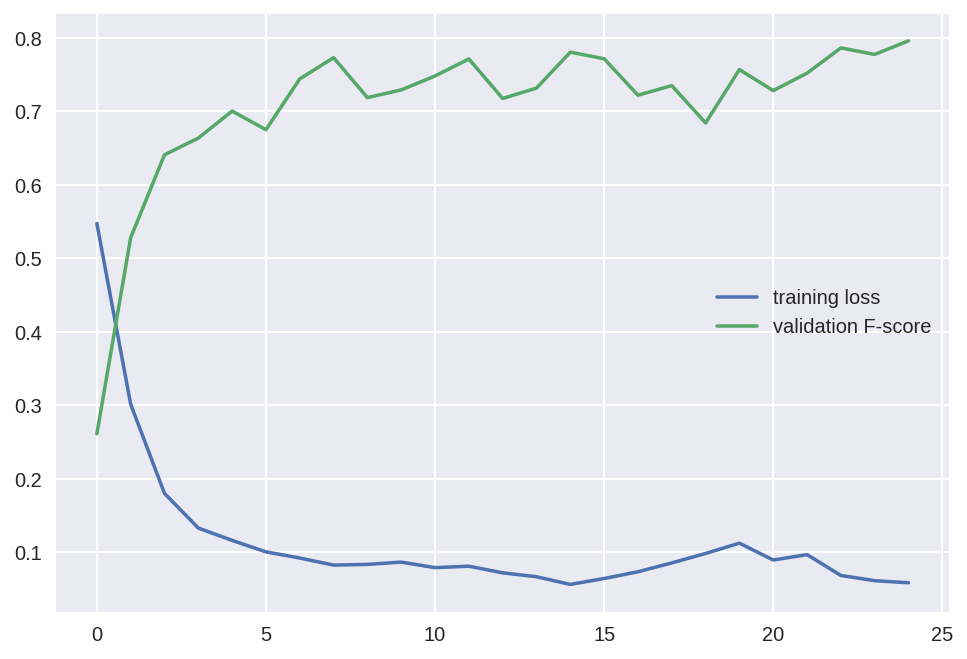

In [14]:
from torchtext.legacy import data
class Tagger:
    
    def __init__(self, lower):
        #self.TEXT = torchtext.data.Field(init_token='<bos>', eos_token='<eos>', sequential=True, lower=lower)
        self.TEXT = torchtext.legacy.data.Field(init_token='<bos>', eos_token='<eos>', sequential=True, lower=lower)
        #self.LABEL = torchtext.data.Field(init_token='<bos>', eos_token='<eos>', sequential=True, unk_token=None)
        self.LABEL = torchtext.legacy.data.Field(init_token='<bos>', eos_token='<eos>', sequential=True, unk_token=None)
        self.fields = [('text', self.TEXT), ('label', self.LABEL)]
        self.device = 'cuda'
        
    def tag(self, sentences):
        # This method applies the trained model to a list of sentences.
        
        # First, create a torchtext Dataset containing the sentences to tag.
        examples = []
        for sen in sentences:
            labels = []*len(sen) # placeholder
           
            #examples.append(torchtext.data.Example.fromlist([sen, labels], self.fields))
            examples.append(torchtext.legacy.data.Example.fromlist([sen, labels], self.fields))
        dataset = torchtext.legacy.data.Dataset(examples, self.fields)
       
       
        iterator = torchtext.legacy.data.BucketIterator(
            dataset,
            device=self.device,
            batch_size=64,
            
            repeat=False,
            train=False,
            sort=False)
        
        # Apply the trained model to all batches.
        out = []
        self.model.eval()
        
        with torch.no_grad():
            
            for batch in iterator:
                # Call the model's predict method. This returns a list of NumPy matrix
                # containing the integer-encoded tags for each sentence.
               
                predicted = self.model.predict(batch.text)
                
                # Convert the integer-encoded tags to tag strings.
                for tokens, pred_sen in zip(sentences, predicted):
                    out.append([self.LABEL.vocab.itos[pred_id] for _, pred_id in zip(tokens, pred_sen[1:])])
        return out

                
    def train(self):
        # Read training and validation data according to the predefined split.
        train_examples = read_data('data1/eng.train.txt', self.fields)
        valid_examples = read_data('data1/eng.test.txt', self.fields)
        #train_examples = read_data('eng.train.openNLP.txt', self.fields)
        #valid_examples = read_data('eng.test.openNLP.txt', self.fields)

        # Count the number of words and sentences.
        n_tokens_train = 0
        n_sentences_train = 0
        for ex in train_examples:
            n_tokens_train += len(ex.text) + 2
            n_sentences_train += 1
        n_tokens_valid = 0       
        for ex in valid_examples:
            n_tokens_valid += len(ex.text)

        # Load the pre-trained embeddings that come with the torchtext library.
        use_pretrained = False
        if use_pretrained:
            print('We are using pre-trained word embeddings.')
            self.TEXT.build_vocab(train_examples, vectors="glove.840B.300d")
        else:  
            print('We are training word embeddings from scratch.')
            self.TEXT.build_vocab(train_examples, max_size=5000)
        print("built vocab from training examples.")
        self.LABEL.build_vocab(train_examples)
    
        # Create one of the models defined above.
        #self.model = RNNTagger(self.TEXT, self.LABEL, emb_dim=300, rnn_size=128, update_pretrained=False)
        self.model = RNNCRFTagger(self.TEXT, self.LABEL, emb_dim=300, rnn_size=128, update_pretrained=False)
    
        self.model.to(self.device)
    
        batch_size = 1024
        n_batches = np.ceil(n_sentences_train / batch_size)

        mean_n_tokens = n_tokens_train / n_batches
       
        train_iterator = torchtext.legacy.data.BucketIterator(
            
            train_examples,
            device=self.device,
            batch_size=batch_size,
            sort_key=lambda x: len(x.text),
            repeat=False,
            train=True,
            sort=True)

        valid_iterator = torchtext.legacy.data.Iterator(
            valid_examples,
            device=self.device,
            batch_size=64,
            sort_key=lambda x: len(x.text),
            repeat=False,
            train=False,
            sort=True)
    
        train_batches = list(train_iterator)
        valid_batches = list(valid_iterator)

        optimizer = torch.optim.Adam(self.model.parameters(), lr=0.01, weight_decay=1e-5)

        n_labels = len(self.LABEL.vocab)

        history = defaultdict(list)    
        
        print("training beginning.")
        n_epochs = 25
        
        for i in range(1, n_epochs + 1):

            t0 = time.time()

            loss_sum = 0

            self.model.train()
            for batch in train_batches:
                
                # Compute the output and loss.
                loss = self.model(batch.text, batch.label) / mean_n_tokens
                
                optimizer.zero_grad()            
                loss.backward()
                optimizer.step()
                loss_sum += loss.item()

            train_loss = loss_sum / n_batches
            history['train_loss'].append(train_loss)

            # Evaluate on the validation set.
            if i % 1 == 0:
                stats = defaultdict(Counter)

                self.model.eval()
                with torch.no_grad():
                    for batch in valid_batches:
                        # Predict the model's output on a batch.
                        predicted = self.model.predict(batch.text)                   
                        # Update the evaluation statistics.
                        evaluate_iob(predicted, batch.label, self.LABEL, stats)
            
                # Compute the overall F-score for the validation set.
                _, _, val_f1 = prf(stats['total'])
                
                history['val_f1'].append(val_f1)
            
                t1 = time.time()
                print(f'Epoch {i}: train loss = {train_loss:.4f}, val f1: {val_f1:.4f}, time = {t1-t0:.4f}')
           
        # After the final evaluation, we print more detailed evaluation statistics, including
        # precision, recall, and F-scores for the different types of named entities.
        print()
        print('Final evaluation on the validation set:')
        p, r, f1 = prf(stats['total'])
        print(f'Overall: P = {p:.4f}, R = {r:.4f}, F1 = {f1:.4f}')
        for label in stats:
            if label != 'total':
                p, r, f1 = prf(stats[label])
                print(f'{label:4s}: P = {p:.4f}, R = {r:.4f}, F1 = {f1:.4f}')
        
        plt.plot(history['train_loss'])
        plt.plot(history['val_f1'])
        plt.legend(['training loss', 'validation F-score'])

tagger = Tagger(lower=False)
tagger.train()

# Analysis of some examples
We'll run the trained named entity recognizer interactively and consider the system's behavior in a few examples. Please note that the system's output can vary a bit, depending on which model you trained, as well as on randomness in the training process.

First, we create a utility function that takes a single sentence, runs the trained system, and prints the words and output tags line by line.

In [15]:
def print_tags(sentence):
    tokens = sentence.split()
    tags = tagger.tag([tokens])[0]
    for token, tag in zip(tokens, tags):
        print(f'{token:12s}{tag}')

In [16]:
print_tags('John XYZXYZABC was born in XYZABC .')

John        I-PER
XYZXYZABC   I-PER
was         O
born        O
in          O
XYZABC      O
.           O


In [17]:
print_tags('John Johnson was born in Moscow , lives in Gothenburg , and works for Chalmers Technical University and the University of Gothenburg .')

John        I-PER
Johnson     I-PER
was         O
born        O
in          O
Moscow      I-LOC
,           O
lives       O
in          O
Gothenburg  O
,           O
and         O
works       O
for         O
Chalmers    O
Technical   O
University  I-ORG
and         O
the         O
University  I-ORG
of          I-ORG
Gothenburg  I-ORG
.           O


In [18]:
print_tags('Paris Hilton lives in New York .')

Paris       I-LOC
Hilton      O
lives       O
in          O
New         I-LOC
York        I-LOC
.           O
